# TP FloatPairs - Recherche Locale

## 1. Imports

In [1]:
# Installation si nécessaire : !pip install jmetalpy numpy pandas matplotlib

from jmetal.algorithm.singleobjective.local_search import LocalSearch
from jmetal.operator.mutation import PolynomialMutation
from jmetal.core.problem import Problem
from jmetal.core.solution import FloatSolution
from jmetal.util.termination_criterion import StoppingByEvaluations

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

%matplotlib inline
print("✓ Imports OK")

✓ Imports OK


## 2. Définition du Problème FloatPairs

In [2]:
class FloatPairsMax(Problem):
    """
    Problème FloatPairs: Maximiser le nombre de paires adjacentes de signes différents
    dans une séquence de nombres flottants.
    
    Pour une séquence de n nombres, le maximum théorique est n-1 paires
    (obtenu par alternance parfaite des signes).
    """
    def __init__(self, number_of_floats: int, min_value: float, max_value: float):
        super().__init__()
        self.number_of_floats = number_of_floats
        self.min_value = min_value
        self.max_value = max_value
        
        self.lower_bound = [self.min_value] * number_of_floats
        self.upper_bound = [self.max_value] * number_of_floats
        
        self.number_of_objectives = 1
        # IMPORTANT: On MINIMISE l'objectif pour être compatible avec JMetalPy
        # On va donc retourner -(nombre de paires)
        self.obj_directions = [self.MINIMIZE]
        self.obj_labels = ['NegativePairsCount']
        
    def number_of_variables(self) -> int:
        return self.number_of_floats
    
    def number_of_objectives(self) -> int:
        return 1
    
    def number_of_constraints(self) -> int:
        return 0
    
    def evaluate(self, solution: FloatSolution) -> FloatSolution:
        """
        Calcule le nombre de paires adjacentes de signes différents.
        Retourne la valeur NÉGATIVE pour minimisation.
        """
        variables = solution.variables
        pairs_count = 0
        
        # Parcours des paires adjacentes
        for i in range(len(variables) - 1):
            # Vérification si les signes sont différents
            if (variables[i] * variables[i + 1] < 0) or \
               (variables[i] == 0 and variables[i + 1] < 0) or \
               (variables[i + 1] == 0 and variables[i] < 0):
                pairs_count += 1
        
        # On retourne la valeur NÉGATIVE pour minimisation
        solution.objectives[0] = -pairs_count
        return solution
    
    def create_solution(self) -> FloatSolution:
        """
        Crée une solution aléatoire
        """
        new_solution = FloatSolution(
            self.lower_bound,
            self.upper_bound,
            self.number_of_objectives,
            self.number_of_constraints()
        )
        
        # Génération de nombres aléatoires dans l'intervalle
        new_solution.variables = [
            random.uniform(self.lower_bound[i], self.upper_bound[i])
            for i in range(self.number_of_variables())
        ]
        
        return new_solution
    
    def name(self) -> str:
        return 'FloatPairsMax'

print("✓ Classe FloatPairsMax définie")

✓ Classe FloatPairsMax définie


## 3. Test du Problème

In [3]:
# Test rapide du problème
print("=== Test du problème FloatPairs ===")

n = 8
bi = -10.00
bs = 10.00

problem = FloatPairsMax(number_of_floats=n, min_value=bi, max_value=bs)

# Test avec solution optimale théorique (alternance)
optimal_solution = problem.create_solution()
optimal_solution.variables = [bs if i % 2 == 0 else bi for i in range(n)]
optimal_solution = problem.evaluate(optimal_solution)

print(f"Solution optimale: {[f'{v:.2f}' for v in optimal_solution.variables]}")
print(f"Fitness (négatif): {optimal_solution.objectives[0]}")
print(f"Nombre de paires réel: {-optimal_solution.objectives[0]}")
print(f"Maximum théorique: {n-1} paires\n")

# Test avec solution aléatoire
random_solution = problem.create_solution()
random_solution = problem.evaluate(random_solution)
print(f"Solution aléatoire: {[f'{v:.2f}' for v in random_solution.variables]}")
print(f"Nombre de paires: {-random_solution.objectives[0]}")

=== Test du problème FloatPairs ===
Solution optimale: ['10.00', '-10.00', '10.00', '-10.00', '10.00', '-10.00', '10.00', '-10.00']
Fitness (négatif): -7
Nombre de paires réel: 7
Maximum théorique: 7 paires

Solution aléatoire: ['0.41', '7.64', '6.30', '4.99', '2.54', '7.47', '6.78', '3.52']
Nombre de paires: 0


## 4. Protocole Expérimental

### 4.1 Paramètres Communs

In [4]:
# Paramètres du problème
N_FLOATS = 100
MIN_VALUE = -10.0
MAX_VALUE = 10.0
OPTIMAL_VALUE = -(N_FLOATS - 1)  # -7 pour minimisation (7 paires pour maximisation)

# Paramètres expérimentaux
MAX_EVALUATIONS = 5000
N_RUNS = 20

# Paramètre de mutation par défaut
MUTATION_DISTRIBUTION_INDEX = 20.0

# Tableau 1 : Paramètres communs
common_params = pd.DataFrame({
    'Paramètre': [
        'Nombre de floats (n)',
        'Intervalle des valeurs',
        'Optimal théorique',
        'Nombre d\'évaluations',
        'Nombre de runs',
        'Mutation distribution index'
    ],
    'Valeur': [
        N_FLOATS,
        f'[{MIN_VALUE}, {MAX_VALUE}]',
        f'{-OPTIMAL_VALUE} paires',
        MAX_EVALUATIONS,
        N_RUNS,
        MUTATION_DISTRIBUTION_INDEX
    ]
})

print("Tableau 1 : Paramètres communs")
print("="*60)
display(common_params)

Tableau 1 : Paramètres communs


,Paramètre,Valeur
0,Nombre de floats (n),100
1,Intervalle des valeurs,"[-10.0, 10.0]"
2,Optimal théorique,99 paires
3,Nombre d'évaluations,5000
4,Nombre de runs,20
5,Mutation distribution index,20.0


### 4.2 Configurations de Recherche Locale Testées

Nous allons tester **5 configurations différentes** de probabilité de mutation :
- **LS1** : `mutation_probability = None` (utilise 1/n par défaut = 0.125)
- **LS2** : `mutation_probability = 0.25` (faible mutation)
- **LS3** : `mutation_probability = 0.5` (mutation modérée)
- **LS4** : `mutation_probability = 0.75` (forte mutation)
- **LS5** : `mutation_probability = 1.0` (mutation maximale)

In [5]:
# Tableau 2 : Configurations testées
configurations = {
    'LS1': {
        'nom': 'Mutation par défaut (1/n)',
        'mutation_probability': None,  # Utilise 1/n par défaut
        'mutation_distribution_index': MUTATION_DISTRIBUTION_INDEX
    },
    'LS2': {
        'nom': 'Mutation faible (0.25)',
        'mutation_probability': 0.25,
        'mutation_distribution_index': MUTATION_DISTRIBUTION_INDEX
    },
    'LS3': {
        'nom': 'Mutation modérée (0.5)',
        'mutation_probability': 0.5,
        'mutation_distribution_index': MUTATION_DISTRIBUTION_INDEX
    },
    'LS4': {
        'nom': 'Mutation forte (0.75)',
        'mutation_probability': 0.75,
        'mutation_distribution_index': MUTATION_DISTRIBUTION_INDEX
    },
    'LS5': {
        'nom': 'Mutation maximale (1.0)',
        'mutation_probability': 1.0,
        'mutation_distribution_index': MUTATION_DISTRIBUTION_INDEX
    }
}

# Création du tableau de configurations
config_data = []
for key, config in configurations.items():
    # Calcul de la probabilité effective
    prob_display = config['mutation_probability'] if config['mutation_probability'] is not None else 1.0 / N_FLOATS
    
    config_data.append({
        'Config': key,
        'Description': config['nom'],
        'Mutation Probability': f"{prob_display:.4f}",
        'Mutation Index': config['mutation_distribution_index']
    })

config_df = pd.DataFrame(config_data)

print("Tableau 2 : Configurations de Recherche Locale")
print("="*60)
display(config_df)

Tableau 2 : Configurations de Recherche Locale


,Config,Description,Mutation Probability,Mutation Index
0,LS1,Mutation par défaut (1/n),0.0100,20.0
1,LS2,Mutation faible (0.25),0.2500,20.0
2,LS3,Mutation modérée (0.5),0.5000,20.0
3,LS4,Mutation forte (0.75),0.7500,20.0
4,LS5,Mutation maximale (1.0),1.0000,20.0


## 5. Fonction d'Exécution d'un Run

In [6]:
def run_local_search(problem, config, max_evaluations, verbose=False):
    """
    Exécute un run de recherche locale avec une configuration donnée.
    
    Args:
        problem: Instance du problème FloatPairsMax
        config: Dictionnaire de configuration
        max_evaluations: Nombre maximum d'évaluations
        verbose: Afficher les logs détaillés
    
    Returns:
        tuple: (fitness, temps_execution)
    """
    # Configuration de l'opérateur de mutation
    # Si mutation_probability est None, on utilise 1/n
    mutation_prob = config['mutation_probability']
    if mutation_prob is None:
        mutation_prob = 1.0 / problem.number_of_variables()
    
    mutation = PolynomialMutation(
        probability=mutation_prob,
        distribution_index=config['mutation_distribution_index']
    )
    
    # Création de l'algorithme de recherche locale
    algorithm = LocalSearch(
        problem=problem,
        mutation=mutation,
        termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations)
    )
    
    # Exécution
    start_time = time.time()
    algorithm.run()
    execution_time = time.time() - start_time
    
    # Récupération du résultat
    result = algorithm.result()
    fitness = result.objectives[0]  # Valeur négative (minimisation)
    
    if verbose:
        print(f"  Fitness: {fitness} ({-fitness} paires)")
        print(f"  Temps: {execution_time:.4f}s")
    
    return fitness, execution_time

print("✓ Fonction run_local_search définie")

✓ Fonction run_local_search définie


## 6. Exécution des Expérimentations

### 6.1 Runs pour Chaque Configuration

Nous allons effectuer **20 runs** pour chaque configuration de recherche locale.

In [7]:
# Création du problème
problem = FloatPairsMax(number_of_floats=N_FLOATS, min_value=MIN_VALUE, max_value=MAX_VALUE)

# Dictionnaire pour stocker tous les résultats
results = {}

# Exécution des runs pour chaque configuration
for config_name, config in configurations.items():
    print(f"\n{'='*80}")
    print(f"Configuration: {config_name} - {config['nom']}")
    print(f"{'='*80}")
    
    fitness_values = []
    execution_times = []
    
    for run in range(1, N_RUNS + 1):
        print(f"\nRun {run}/{N_RUNS}", end=" ")
        
        fitness, exec_time = run_local_search(
            problem=problem,
            config=config,
            max_evaluations=MAX_EVALUATIONS,
            verbose=False
        )
        
        fitness_values.append(fitness)
        execution_times.append(exec_time)
        
        # Affichage simplifié
        print(f"→ Fitness: {fitness:.2f} ({-fitness:.0f} paires) | Temps: {exec_time:.4f}s")
    
    # Stockage des résultats
    results[config_name] = {
        'fitness_values': fitness_values,
        'execution_times': execution_times
    }
    
    # Statistiques de la configuration
    print(f"\n{'─'*80}")
    print(f"Statistiques pour {config_name}:")
    print(f"  Fitness moyen: {np.mean(fitness_values):.2f} paires")
    print(f"  Médiane: {np.median(fitness_values):.2f}")
    print(f"  Écart-type: {np.std(fitness_values):.4f}")
    print(f"  Min: {np.min(fitness_values):.2f} | Max: {np.max(fitness_values):.2f}")
    print(f"  Temps moyen: {np.mean(execution_times):.4f}s")
    print(f"{'─'*80}")

print(f"\n{'='*80}")
print("✓ Toutes les expérimentations sont terminées !")
print(f"{'='*80}")

[2026-02-02 10:29:54,939] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...



Configuration: LS1 - Mutation par défaut (1/n)

Run 1/20 

[2026-02-02 10:29:54,944] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:29:54,945] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:29:54,946] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-02 10:29:55,717] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:29:55,717] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:29:55,718] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:29:55,718] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:29:55,719] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -71.00 (71 paires) | Temps: 0.7779s

Run 2/20 

[2026-02-02 10:29:56,492] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:29:56,493] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:29:56,493] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:29:56,494] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:29:56,494] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -74.00 (74 paires) | Temps: 0.7750s

Run 3/20 

[2026-02-02 10:29:57,473] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:29:57,475] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:29:57,477] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:29:57,479] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:29:57,482] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -67.00 (67 paires) | Temps: 0.9823s

Run 4/20 

[2026-02-02 10:29:58,945] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:29:58,946] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:29:58,946] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:29:58,949] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:29:58,951] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -74.00 (74 paires) | Temps: 1.4702s

Run 5/20 

[2026-02-02 10:29:59,918] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:29:59,919] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:29:59,920] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:29:59,922] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:29:59,923] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -76.00 (76 paires) | Temps: 0.9735s

Run 6/20 

[2026-02-02 10:30:01,348] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:01,349] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:01,349] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:01,351] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:01,351] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -73.00 (73 paires) | Temps: 1.4295s

Run 7/20 

[2026-02-02 10:30:02,611] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:02,613] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:02,616] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:02,625] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:02,630] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -66.00 (66 paires) | Temps: 1.2634s

Run 8/20 

[2026-02-02 10:30:04,332] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:04,337] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:04,342] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:04,344] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:04,347] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -68.00 (68 paires) | Temps: 1.7216s

Run 9/20 

[2026-02-02 10:30:05,936] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:05,937] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:05,938] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:05,943] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:05,944] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -64.00 (64 paires) | Temps: 1.5998s

Run 10/20 

[2026-02-02 10:30:07,400] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:07,402] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:07,405] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:07,407] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:07,412] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -72.00 (72 paires) | Temps: 1.4645s

Run 11/20 

[2026-02-02 10:30:08,603] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:08,604] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:08,605] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:08,606] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:08,606] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -73.00 (73 paires) | Temps: 1.2023s

Run 12/20 

[2026-02-02 10:30:09,464] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:09,465] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:09,465] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:09,466] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:09,466] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -70.00 (70 paires) | Temps: 0.8607s

Run 13/20 

[2026-02-02 10:30:10,269] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:10,270] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:10,270] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:10,271] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:10,272] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -73.00 (73 paires) | Temps: 0.8047s

Run 14/20 

[2026-02-02 10:30:11,097] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:11,097] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:11,098] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:11,099] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:11,099] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -72.00 (72 paires) | Temps: 0.8276s

Run 15/20 

[2026-02-02 10:30:11,921] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:11,922] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:11,923] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:11,923] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:11,924] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -75.00 (75 paires) | Temps: 0.8246s

Run 16/20 

[2026-02-02 10:30:12,765] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:12,766] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:12,766] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:12,767] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:12,768] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -74.00 (74 paires) | Temps: 0.8436s

Run 17/20 

[2026-02-02 10:30:13,610] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:13,610] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:13,611] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:13,611] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:13,612] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -71.00 (71 paires) | Temps: 0.8444s

Run 18/20 

[2026-02-02 10:30:14,461] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:14,462] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:14,462] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:14,463] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:14,463] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -76.00 (76 paires) | Temps: 0.8513s

Run 19/20 

[2026-02-02 10:30:15,366] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:15,367] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:15,368] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:15,369] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:15,369] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -65.00 (65 paires) | Temps: 0.9055s

Run 20/20 

[2026-02-02 10:30:16,266] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:16,270] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:16,271] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:16,272] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:16,274] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -75.00 (75 paires) | Temps: 0.8994s

────────────────────────────────────────────────────────────────────────────────
Statistiques pour LS1:
  Fitness moyen: -71.45 paires
  Médiane: -72.50
  Écart-type: 3.5704
  Min: -76.00 | Max: -64.00
  Temps moyen: 1.0661s
────────────────────────────────────────────────────────────────────────────────

Configuration: LS2 - Mutation faible (0.25)

Run 1/20 

[2026-02-02 10:30:17,235] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:17,236] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:17,236] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:17,237] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:17,239] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -86.00 (86 paires) | Temps: 0.9653s

Run 2/20 

[2026-02-02 10:30:18,145] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:18,146] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:18,146] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:18,147] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:18,148] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -89.00 (89 paires) | Temps: 0.9100s

Run 3/20 

[2026-02-02 10:30:19,033] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:19,034] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:19,034] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:19,035] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:19,036] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -90.00 (90 paires) | Temps: 0.8880s

Run 4/20 

[2026-02-02 10:30:19,886] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:19,887] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:19,888] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:19,888] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:19,889] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -88.00 (88 paires) | Temps: 0.8526s

Run 5/20 

[2026-02-02 10:30:20,677] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:20,678] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:20,678] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:20,679] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:20,679] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -93.00 (93 paires) | Temps: 0.7907s

Run 6/20 

[2026-02-02 10:30:21,697] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:21,698] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:21,698] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:21,699] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:21,700] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -91.00 (91 paires) | Temps: 1.0199s

Run 7/20 

[2026-02-02 10:30:22,609] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:22,609] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:22,610] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:22,610] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:22,611] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -88.00 (88 paires) | Temps: 0.9117s

Run 8/20 

[2026-02-02 10:30:23,482] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:23,483] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:23,484] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:23,484] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:23,485] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -91.00 (91 paires) | Temps: 0.8737s

Run 9/20 

[2026-02-02 10:30:24,521] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:24,522] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:24,522] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:24,523] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:24,523] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -89.00 (89 paires) | Temps: 1.0386s

Run 10/20 

[2026-02-02 10:30:25,263] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:25,265] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:25,269] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:25,270] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:25,272] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -91.00 (91 paires) | Temps: 0.7423s

Run 11/20 

[2026-02-02 10:30:26,299] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:26,300] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:26,300] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:26,301] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:26,302] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -88.00 (88 paires) | Temps: 1.0352s

Run 12/20 

[2026-02-02 10:30:27,247] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:27,248] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:27,249] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:27,250] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:27,250] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -89.00 (89 paires) | Temps: 0.9482s

Run 13/20 

[2026-02-02 10:30:28,552] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:28,553] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:28,554] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:28,556] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:28,557] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -90.00 (90 paires) | Temps: 1.3050s

Run 14/20 

[2026-02-02 10:30:29,482] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:29,483] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:29,484] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:29,485] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:29,485] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -90.00 (90 paires) | Temps: 0.9299s

Run 15/20 

[2026-02-02 10:30:30,740] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:30,741] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:30,741] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:30,742] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:30,742] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -87.00 (87 paires) | Temps: 1.2573s

Run 16/20 

[2026-02-02 10:30:31,903] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:31,904] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:31,905] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:31,906] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:31,906] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -91.00 (91 paires) | Temps: 1.1634s

Run 17/20 

[2026-02-02 10:30:33,135] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:33,136] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:33,137] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:33,138] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:33,139] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -94.00 (94 paires) | Temps: 1.2318s

Run 18/20 

[2026-02-02 10:30:34,356] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:34,357] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:34,358] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:34,359] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:34,359] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -90.00 (90 paires) | Temps: 1.2207s

Run 19/20 

[2026-02-02 10:30:35,161] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:35,162] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:35,162] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:35,163] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:35,164] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -88.00 (88 paires) | Temps: 0.8045s

Run 20/20 

[2026-02-02 10:30:35,979] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:35,980] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:35,981] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:35,981] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:35,982] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -91.00 (91 paires) | Temps: 0.8178s

────────────────────────────────────────────────────────────────────────────────
Statistiques pour LS2:
  Fitness moyen: -89.70 paires
  Médiane: -90.00
  Écart-type: 1.9000
  Min: -94.00 | Max: -86.00
  Temps moyen: 0.9853s
────────────────────────────────────────────────────────────────────────────────

Configuration: LS3 - Mutation modérée (0.5)

Run 1/20 

[2026-02-02 10:30:37,286] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:37,287] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:37,287] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:37,289] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:37,290] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -89.00 (89 paires) | Temps: 1.3064s

Run 2/20 

[2026-02-02 10:30:38,107] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:38,108] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:38,108] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:38,109] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:38,109] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -90.00 (90 paires) | Temps: 0.8213s

Run 3/20 

[2026-02-02 10:30:39,104] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:39,105] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:39,105] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:39,106] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:39,107] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -91.00 (91 paires) | Temps: 0.9968s

Run 4/20 

[2026-02-02 10:30:39,991] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:39,992] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:39,994] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:39,995] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:39,997] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -88.00 (88 paires) | Temps: 0.8873s

Run 5/20 

[2026-02-02 10:30:41,065] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:41,066] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:41,066] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:41,067] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:41,067] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -91.00 (91 paires) | Temps: 1.0733s

Run 6/20 

[2026-02-02 10:30:41,965] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:41,966] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:41,967] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:41,967] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:41,967] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -88.00 (88 paires) | Temps: 0.9002s

Run 7/20 

[2026-02-02 10:30:43,040] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:43,041] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:43,042] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:43,042] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:43,043] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -89.00 (89 paires) | Temps: 1.0749s

Run 8/20 

[2026-02-02 10:30:44,003] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:44,004] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:44,004] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:44,005] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:44,006] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -89.00 (89 paires) | Temps: 0.9623s

Run 9/20 

[2026-02-02 10:30:44,861] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:44,862] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:44,863] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:44,864] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:44,864] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -91.00 (91 paires) | Temps: 0.8584s

Run 10/20 

[2026-02-02 10:30:45,690] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:45,691] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:45,691] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:45,692] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:45,692] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -90.00 (90 paires) | Temps: 0.8286s

Run 11/20 

[2026-02-02 10:30:46,816] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:46,817] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:46,818] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:46,818] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:46,819] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -89.00 (89 paires) | Temps: 1.1262s

Run 12/20 

[2026-02-02 10:30:47,682] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:47,683] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:47,683] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:47,684] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:47,684] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -89.00 (89 paires) | Temps: 0.8655s

Run 13/20 

[2026-02-02 10:30:48,592] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:48,592] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:48,593] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:48,594] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:48,595] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -92.00 (92 paires) | Temps: 0.9094s

Run 14/20 

[2026-02-02 10:30:49,497] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:49,498] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:49,499] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:49,500] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:49,501] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -87.00 (87 paires) | Temps: 0.9056s

Run 15/20 

[2026-02-02 10:30:50,375] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:50,376] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:50,377] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:50,377] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:50,378] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -89.00 (89 paires) | Temps: 0.8778s

Run 16/20 

[2026-02-02 10:30:51,325] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:51,326] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:51,327] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:51,329] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:51,330] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -91.00 (91 paires) | Temps: 0.9500s

Run 17/20 

[2026-02-02 10:30:52,176] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:52,177] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:52,177] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:52,178] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:52,179] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -89.00 (89 paires) | Temps: 0.8504s

Run 18/20 

[2026-02-02 10:30:53,194] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:53,194] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:53,195] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:53,195] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:53,196] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -89.00 (89 paires) | Temps: 1.0175s

Run 19/20 

[2026-02-02 10:30:54,044] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:54,045] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:54,045] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:54,046] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:54,047] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -90.00 (90 paires) | Temps: 0.8504s

Run 20/20 

[2026-02-02 10:30:55,094] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:55,095] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:55,095] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:55,096] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:55,096] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -90.00 (90 paires) | Temps: 1.0497s

────────────────────────────────────────────────────────────────────────────────
Statistiques pour LS3:
  Fitness moyen: -89.55 paires
  Médiane: -89.00
  Écart-type: 1.2031
  Min: -92.00 | Max: -87.00
  Temps moyen: 0.9556s
────────────────────────────────────────────────────────────────────────────────

Configuration: LS4 - Mutation forte (0.75)

Run 1/20 

[2026-02-02 10:30:56,060] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:56,061] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:56,062] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:56,062] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:56,063] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -90.00 (90 paires) | Temps: 0.9659s

Run 2/20 

[2026-02-02 10:30:57,062] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:57,063] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:57,063] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:57,064] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:57,064] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -88.00 (88 paires) | Temps: 1.0016s

Run 3/20 

[2026-02-02 10:30:57,895] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:57,895] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:57,896] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:57,896] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:57,897] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -89.00 (89 paires) | Temps: 0.8328s

Run 4/20 

[2026-02-02 10:30:58,890] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:58,891] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:58,892] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:58,892] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:58,893] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -90.00 (90 paires) | Temps: 0.9955s

Run 5/20 

[2026-02-02 10:30:59,947] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:30:59,948] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:30:59,949] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:30:59,950] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:30:59,951] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -89.00 (89 paires) | Temps: 1.0567s

Run 6/20 

[2026-02-02 10:31:00,986] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:00,987] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:00,988] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:00,989] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:00,990] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -90.00 (90 paires) | Temps: 1.0393s

Run 7/20 

[2026-02-02 10:31:01,889] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:01,891] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:01,893] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:01,893] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:01,894] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -90.00 (90 paires) | Temps: 0.9032s

Run 8/20 

[2026-02-02 10:31:02,811] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:02,811] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:02,812] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:02,812] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:02,813] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -87.00 (87 paires) | Temps: 0.9208s

Run 9/20 

[2026-02-02 10:31:03,673] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:03,674] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:03,675] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:03,675] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:03,677] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -90.00 (90 paires) | Temps: 0.8624s

Run 10/20 

[2026-02-02 10:31:04,695] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:04,696] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:04,696] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:04,697] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:04,697] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -89.00 (89 paires) | Temps: 1.0217s

Run 11/20 

[2026-02-02 10:31:05,793] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:05,795] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:05,796] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:05,798] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:05,800] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -84.00 (84 paires) | Temps: 1.0985s

Run 12/20 

[2026-02-02 10:31:06,847] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:06,848] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:06,849] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:06,850] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:06,851] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -85.00 (85 paires) | Temps: 1.0532s

Run 13/20 

[2026-02-02 10:31:07,758] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:07,758] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:07,759] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:07,760] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:07,760] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -89.00 (89 paires) | Temps: 0.9103s

Run 14/20 

[2026-02-02 10:31:08,620] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:08,620] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:08,621] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:08,622] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:08,622] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -85.00 (85 paires) | Temps: 0.8617s

Run 15/20 

[2026-02-02 10:31:09,489] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:09,490] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:09,490] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:09,491] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:09,492] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -87.00 (87 paires) | Temps: 0.8693s

Run 16/20 

[2026-02-02 10:31:10,405] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:10,406] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:10,406] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:10,407] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:10,407] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -86.00 (86 paires) | Temps: 0.9160s

Run 17/20 

[2026-02-02 10:31:11,427] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:11,428] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:11,428] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:11,429] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:11,429] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -88.00 (88 paires) | Temps: 1.0218s

Run 18/20 

[2026-02-02 10:31:12,310] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:12,311] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:12,311] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:12,313] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:12,314] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -91.00 (91 paires) | Temps: 0.8832s

Run 19/20 

[2026-02-02 10:31:13,279] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:13,280] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:13,281] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:13,281] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:13,282] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -89.00 (89 paires) | Temps: 0.9692s

Run 20/20 

[2026-02-02 10:31:14,163] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:14,164] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:14,165] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:14,165] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:14,166] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -86.00 (86 paires) | Temps: 0.8833s

────────────────────────────────────────────────────────────────────────────────
Statistiques pour LS4:
  Fitness moyen: -88.10 paires
  Médiane: -89.00
  Écart-type: 1.9723
  Min: -91.00 | Max: -84.00
  Temps moyen: 0.9533s
────────────────────────────────────────────────────────────────────────────────

Configuration: LS5 - Mutation maximale (1.0)

Run 1/20 

[2026-02-02 10:31:15,091] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:15,092] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:15,092] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:15,093] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:15,094] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -84.00 (84 paires) | Temps: 0.9276s

Run 2/20 

[2026-02-02 10:31:16,047] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:16,047] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:16,048] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:16,049] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:16,050] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -91.00 (91 paires) | Temps: 0.9557s

Run 3/20 

[2026-02-02 10:31:17,002] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:17,003] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:17,003] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:17,004] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:17,006] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -84.00 (84 paires) | Temps: 0.9551s

Run 4/20 

[2026-02-02 10:31:18,115] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:18,119] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:18,139] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:18,172] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:18,179] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -90.00 (90 paires) | Temps: 1.1149s

Run 5/20 

[2026-02-02 10:31:19,356] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:19,357] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:19,357] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:19,358] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:19,359] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -88.00 (88 paires) | Temps: 1.2374s

Run 6/20 

[2026-02-02 10:31:20,474] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:20,474] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:20,475] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:20,476] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:20,476] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -87.00 (87 paires) | Temps: 1.1174s

Run 7/20 

[2026-02-02 10:31:21,532] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:21,533] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:21,534] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:21,534] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:21,535] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -84.00 (84 paires) | Temps: 1.0586s

Run 8/20 

[2026-02-02 10:31:22,549] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:22,550] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:22,551] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:22,552] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:22,552] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -89.00 (89 paires) | Temps: 1.0167s

Run 9/20 

[2026-02-02 10:31:23,598] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:23,599] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:23,599] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:23,600] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:23,600] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -86.00 (86 paires) | Temps: 1.0486s

Run 10/20 

[2026-02-02 10:31:24,532] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:24,532] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:24,533] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:24,534] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:24,534] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -87.00 (87 paires) | Temps: 0.9337s

Run 11/20 

[2026-02-02 10:31:25,461] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:25,462] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:25,462] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:25,463] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:25,463] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -86.00 (86 paires) | Temps: 0.9291s

Run 12/20 

[2026-02-02 10:31:26,530] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:26,530] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:26,531] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:26,532] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:26,532] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -88.00 (88 paires) | Temps: 1.0687s

Run 13/20 

[2026-02-02 10:31:27,555] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:27,556] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:27,557] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:27,558] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:27,558] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -86.00 (86 paires) | Temps: 1.0254s

Run 14/20 

[2026-02-02 10:31:28,496] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:28,497] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:28,497] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:28,498] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:28,498] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -87.00 (87 paires) | Temps: 0.9405s

Run 15/20 

[2026-02-02 10:31:29,439] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:29,440] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:29,440] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:29,441] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:29,442] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -84.00 (84 paires) | Temps: 0.9430s

Run 16/20 

[2026-02-02 10:31:30,416] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:30,417] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:30,418] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:30,419] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:30,421] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -86.00 (86 paires) | Temps: 0.9773s

Run 17/20 

[2026-02-02 10:31:31,355] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:31,355] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:31,356] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:31,356] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:31,357] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -87.00 (87 paires) | Temps: 0.9380s

Run 18/20 

[2026-02-02 10:31:32,375] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:32,376] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:32,377] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:32,378] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:32,379] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -90.00 (90 paires) | Temps: 1.0210s

Run 19/20 

[2026-02-02 10:31:33,312] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:31:33,312] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:31:33,313] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:31:33,313] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:31:33,314] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -83.00 (83 paires) | Temps: 0.9359s

Run 20/20 

[2026-02-02 10:31:34,201] [jmetal.core.algorithm] [DEBUG] Finished!


→ Fitness: -89.00 (89 paires) | Temps: 0.8889s

────────────────────────────────────────────────────────────────────────────────
Statistiques pour LS5:
  Fitness moyen: -86.80 paires
  Médiane: -87.00
  Écart-type: 2.2271
  Min: -91.00 | Max: -83.00
  Temps moyen: 1.0017s
────────────────────────────────────────────────────────────────────────────────

✓ Toutes les expérimentations sont terminées !


## 7. Analyse des Résultats

### 7.1 Calcul des Statistiques Complètes

In [8]:
# Calcul des statistiques pour chaque configuration
for config_name in results:
    fitness_vals = results[config_name]['fitness_values']
    time_vals = results[config_name]['execution_times']
    
    results[config_name]['mean'] = np.mean(fitness_vals)
    results[config_name]['median'] = np.median(fitness_vals)
    results[config_name]['std'] = np.std(fitness_vals)
    results[config_name]['min'] = np.min(fitness_vals)
    results[config_name]['max'] = np.max(fitness_vals)
    results[config_name]['time_mean'] = np.mean(time_vals)
    results[config_name]['time_std'] = np.std(time_vals)
    
    # Taux de succès (atteint l'optimal)
    optimal_count = sum(1 for f in fitness_vals if f == OPTIMAL_VALUE)
    results[config_name]['success_rate'] = (optimal_count / N_RUNS) * 100

print("✓ Statistiques calculées")

✓ Statistiques calculées


### 7.2 Tableau Récapitulatif des Résultats

In [9]:
# Création du tableau récapitulatif
summary_data = []
for config_name, res in results.items():
    summary_data.append({
        'Configuration': config_name,
        'Description': configurations[config_name]['nom'],
        'Moyenne (paires)': f"{-res['mean']:.2f}",
        'Médiane': f"{-res['median']:.2f}",
        'Écart-type': f"{res['std']:.4f}",
        'Min': f"{-res['min']:.2f}",
        'Max': f"{-res['max']:.2f}",
        'Taux succès (%)': f"{res['success_rate']:.1f}",
        'Temps moyen (s)': f"{res['time_mean']:.4f}",
        'Temps σ': f"{res['time_std']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)

print("Tableau 3 : Résultats des Recherches Locales")
print("="*120)
display(summary_df)

# Export en CSV
#summary_df.to_csv('floatpairs_local_search_summary.csv', index=False)
print("\n✓ Tableau exporté dans 'floatpairs_local_search_summary.csv'")

Tableau 3 : Résultats des Recherches Locales


,Configuration,Description,Moyenne (paires),Médiane,Écart-type,Min,Max,Taux succès (%),Temps moyen (s),Temps σ
0,LS1,Mutation par défaut (1/n),71.45,72.50,3.5704,76.00,64.00,0.0,1.0661,0.3028
1,LS2,Mutation faible (0.25),89.70,90.00,1.9000,94.00,86.00,0.0,0.9853,0.1649
2,LS3,Mutation modérée (0.5),89.55,89.00,1.2031,92.00,87.00,0.0,0.9556,0.1198
3,LS4,Mutation forte (0.75),88.10,89.00,1.9723,91.00,84.00,0.0,0.9533,0.0768
4,LS5,Mutation maximale (1.0),86.80,87.00,2.2271,91.00,83.00,0.0,1.0017,0.0841



✓ Tableau exporté dans 'floatpairs_local_search_summary.csv'


### 8.1 Distribution des Résultats (Box Plot)

/var/folders/rh/xt3snpjn7ng64htp00_8m9nw0000gn/T/ipykernel_19965/473382884.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_for_boxplot, labels=labels, patch_artist=True,


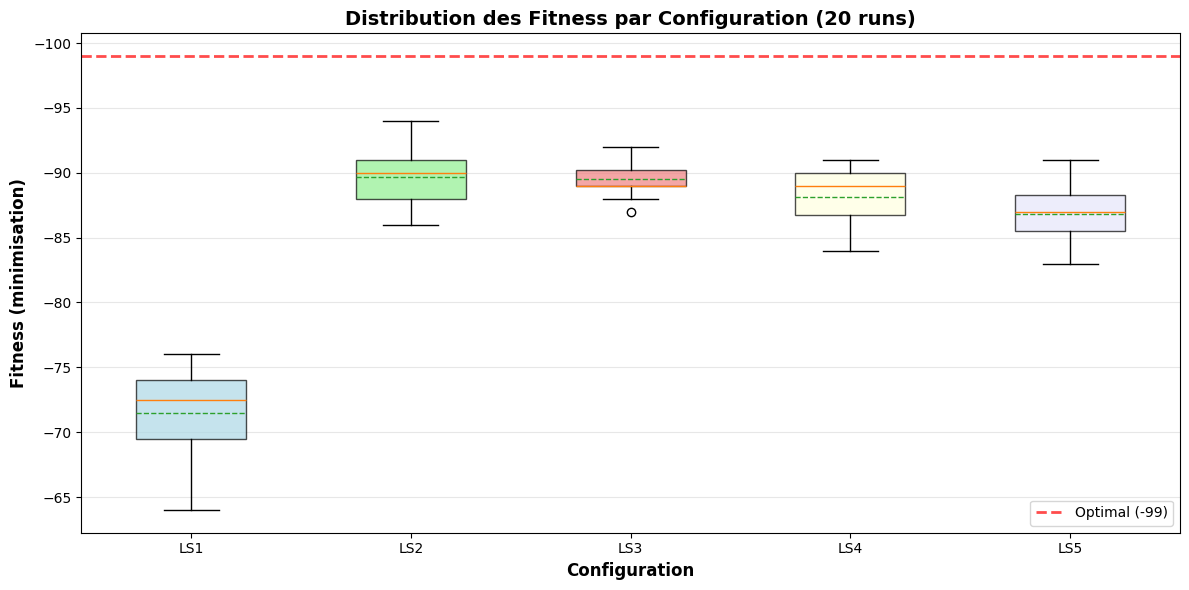


✓ Boxplots générés avec succès


In [10]:
# Graphique 1: Boxplots
fig, ax = plt.subplots(figsize=(12, 6))

# Préparation des données pour boxplot
data_for_boxplot = [results[c]['fitness_values'] for c in configurations.keys()]
labels = list(configurations.keys())

# Création des boxplots
bp = ax.boxplot(data_for_boxplot, labels=labels, patch_artist=True,
                showmeans=True, meanline=True)

# Coloration des boîtes
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lavender']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Configuration du graphique
ax.set_ylabel('Fitness (minimisation)', fontsize=12, fontweight='bold')
ax.set_xlabel('Configuration', fontsize=12, fontweight='bold')
ax.set_title('Distribution des Fitness par Configuration (20 runs)', 
             fontsize=14, fontweight='bold')
ax.axhline(y=OPTIMAL_VALUE, color='r', linestyle='--', linewidth=2, 
           label=f'Optimal ({OPTIMAL_VALUE})', alpha=0.7)
ax.grid(True, alpha=0.3, axis='y')
ax.legend(loc='lower right', fontsize=10)

# Inverser l'axe Y pour que l'optimal soit en haut
ax.invert_yaxis()

plt.tight_layout()
#plt.savefig('floatpairs_ls_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Boxplots générés avec succès")

### 8.2 Graphiques Complémentaires (Moyenne, Distance, Temps)

/var/folders/rh/xt3snpjn7ng64htp00_8m9nw0000gn/T/ipykernel_19965/2022224857.py:80: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/salimtitouche/FloatPairs/jmetalpy_env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


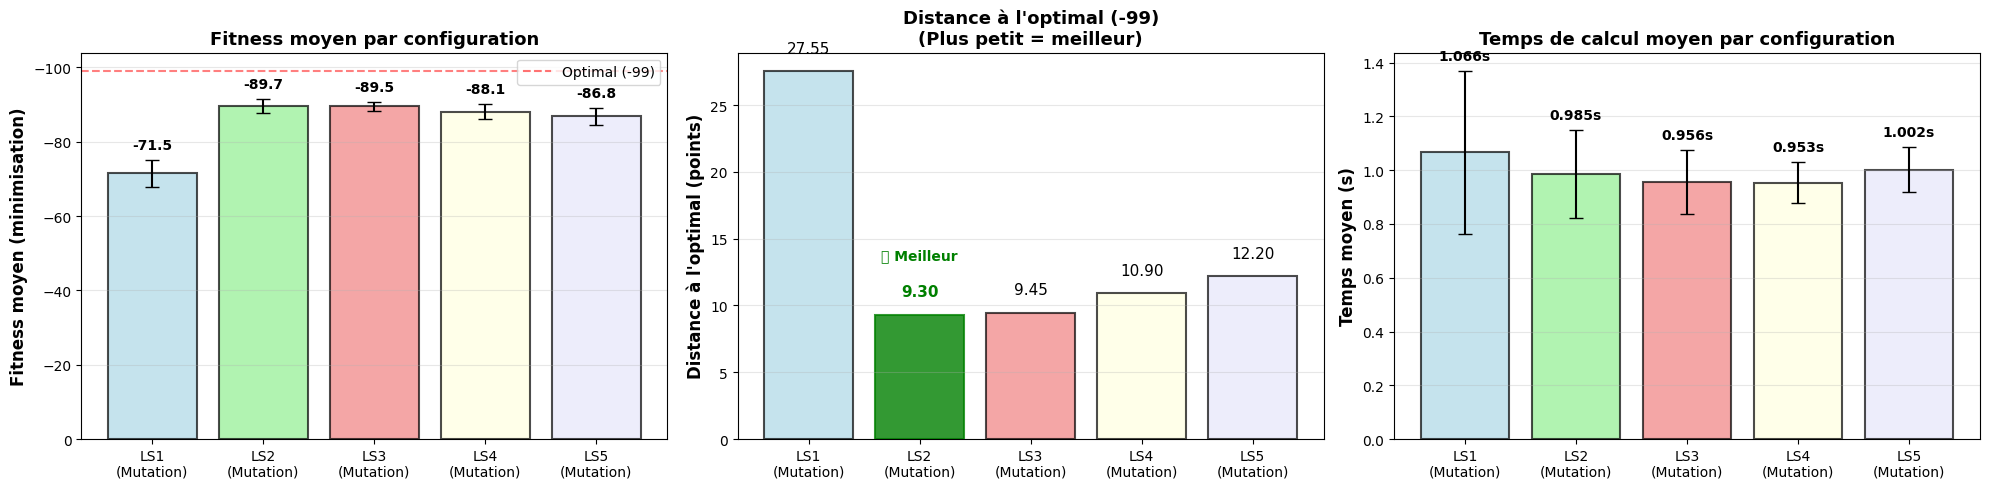


✓ Graphiques complémentaires générés

ANALYSE DES DISTANCES À L'OPTIMAL
LS2 : 9.30 points de l'optimal
LS3 : 9.45 points de l'optimal
LS4 : 10.90 points de l'optimal
LS5 : 12.20 points de l'optimal
LS1 : 27.55 points de l'optimal


In [11]:
# Graphiques complémentaires : Moyenne + Distance + Temps
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

configs = list(configurations.keys())
means = [results[c]['mean'] for c in configs]
stds = [results[c]['std'] for c in configs]
x_pos = np.arange(len(configs))

# Graphique 1 : Barres des moyennes avec écart-type
axes[0].bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, 
           color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([f'{c}\n({configurations[c]["nom"].split()[0]})' for c in configs])
axes[0].set_ylabel('Fitness moyen (minimisation)', fontsize=12, fontweight='bold')
axes[0].set_title('Fitness moyen par configuration', fontsize=13, fontweight='bold')

# Inverser l'axe Y
axes[0].invert_yaxis()

# Ligne de référence
axes[0].axhline(y=OPTIMAL_VALUE, color='r', linestyle='--', alpha=0.5, 
                label=f'Optimal ({OPTIMAL_VALUE})')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].legend(loc='upper right')

# Ajout des valeurs sur les barres (dynamique)
text_offset = abs(OPTIMAL_VALUE) * 0.03  # 3% de la valeur optimale
for i, (m, s) in enumerate(zip(means, stds)):
    axes[0].text(i, m - s - text_offset, f'{m:.1f}', ha='center', fontsize=10, fontweight='bold')

# Graphique 2 : Distance à l'optimal
distances = [abs(OPTIMAL_VALUE - results[c]['mean']) for c in configs]
max_distance = max(distances) if distances else 1  # Éviter division par zéro

bars = axes[1].bar(x_pos, distances, alpha=0.7, color=colors,
                   edgecolor='black', linewidth=1.5)

# Mettre en vert la meilleure (distance la plus petite)
best_idx = distances.index(min(distances))
bars[best_idx].set_color('green')
bars[best_idx].set_alpha(0.8)

axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([f'{c}\n({configurations[c]["nom"].split()[0]})' for c in configs])
axes[1].set_ylabel('Distance à l\'optimal (points)', fontsize=12, fontweight='bold')
axes[1].set_title(f'Distance à l\'optimal ({OPTIMAL_VALUE})\n(Plus petit = meilleur)', 
                  fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Ajout des valeurs sur les barres (dynamique)
text_offset_dist = max_distance * 0.05  # 5% de la distance max
for i, d in enumerate(distances):
    color = 'green' if i == best_idx else 'black'
    weight = 'bold' if i == best_idx else 'normal'
    axes[1].text(i, d + text_offset_dist, f'{d:.2f}', ha='center', fontsize=11, 
                fontweight=weight, color=color)

# Annotation pour le meilleur (dynamique)
axes[1].text(best_idx, distances[best_idx] + text_offset_dist * 3, '⭐ Meilleur', 
            ha='center', fontsize=10, color='green', fontweight='bold')

# Graphique 3 : Temps de calcul moyen
times = [results[c]['time_mean'] for c in configs]
time_stds = [results[c]['time_std'] for c in configs]
max_time = max([t + ts for t, ts in zip(times, time_stds)]) if times else 1

axes[2].bar(x_pos, times, yerr=time_stds, capsize=5, alpha=0.7,
           color=colors, edgecolor='black', linewidth=1.5)
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels([f'{c}\n({configurations[c]["nom"].split()[0]})' for c in configs])
axes[2].set_ylabel('Temps moyen (s)', fontsize=12, fontweight='bold')
axes[2].set_title('Temps de calcul moyen par configuration', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

# Ajout des valeurs sur les barres (dynamique)
text_offset_time = max_time * 0.03  # 3% du temps max
for i, (t, ts) in enumerate(zip(times, time_stds)):
    axes[2].text(i, t + ts + text_offset_time, f'{t:.3f}s', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
#plt.savefig('floatpairs_ls_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Graphiques complémentaires générés")

print("\n" + "="*60)
print("ANALYSE DES DISTANCES À L'OPTIMAL")
print("="*60)

# Afficher les distances triées
distances_with_names = [(configs[i], distances[i]) for i in range(len(configs))]
distances_with_names.sort(key=lambda x: x[1])

for i, (name, dist) in enumerate(distances_with_names, 1):
    print(f"{name} : {dist:.2f} points de l'optimal")

### 8.3 Évolution de la Performance selon la Probabilité de Mutation

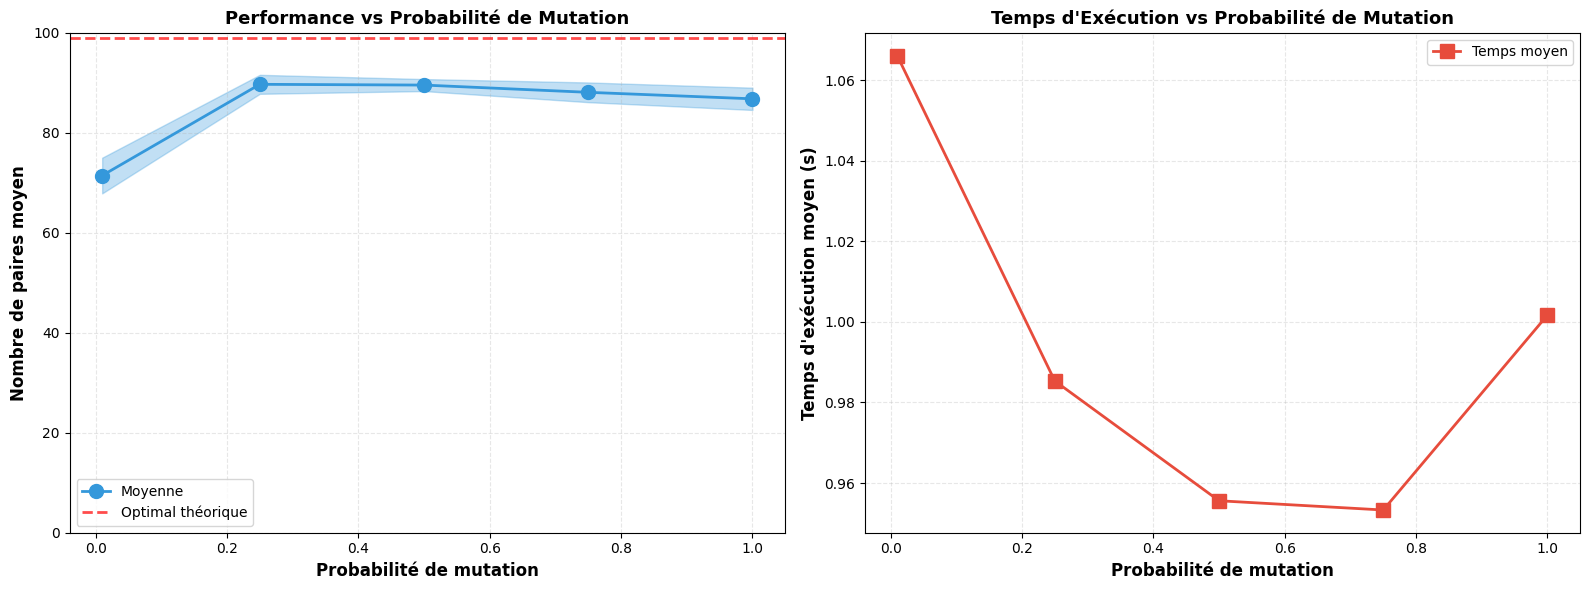

✓ Graphique 3 sauvegardé: 'floatpairs_ls_evolution.png'


In [12]:
# Graphique 3: Évolution selon probabilité de mutation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Probabilités de mutation
mutation_probs = [1.0/N_FLOATS, 0.25, 0.5, 0.75, 1.0]
config_names = list(results.keys())
means_pairs = []
stds_pairs = []
times = []

for config_name in config_names:
    means_pairs.append(-results[config_name]['mean'])
    stds_pairs.append(results[config_name]['std'])
    times.append(results[config_name]['time_mean'])

# Sous-graphique 1: Performance vs Probabilité
ax1.plot(mutation_probs, means_pairs, 'o-', linewidth=2, markersize=10, 
         color='#3498db', label='Moyenne')
ax1.fill_between(mutation_probs, 
                 [m - s for m, s in zip(means_pairs, stds_pairs)],
                 [m + s for m, s in zip(means_pairs, stds_pairs)],
                 alpha=0.3, color='#3498db')
ax1.axhline(y=-OPTIMAL_VALUE, color='red', linestyle='--', linewidth=2, 
            label='Optimal théorique', alpha=0.7)

# Limites dynamiques de l'axe Y
y_max = -OPTIMAL_VALUE + 1
ax1.set_ylim([0, y_max])

ax1.set_xlabel('Probabilité de mutation', fontsize=12, fontweight='bold')
ax1.set_ylabel('Nombre de paires moyen', fontsize=12, fontweight='bold')
ax1.set_title('Performance vs Probabilité de Mutation', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3, linestyle='--')

# Sous-graphique 2: Temps vs Probabilité
ax2.plot(mutation_probs, times, 's-', linewidth=2, markersize=10, 
         color='#e74c3c', label='Temps moyen')
ax2.set_xlabel('Probabilité de mutation', fontsize=12, fontweight='bold')
ax2.set_ylabel('Temps d\'exécution moyen (s)', fontsize=12, fontweight='bold')
ax2.set_title('Temps d\'Exécution vs Probabilité de Mutation', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
#plt.savefig('floatpairs_ls_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Graphique 3 sauvegardé: 'floatpairs_ls_evolution.png'")

### 8.4 Taux de Succès par Configuration

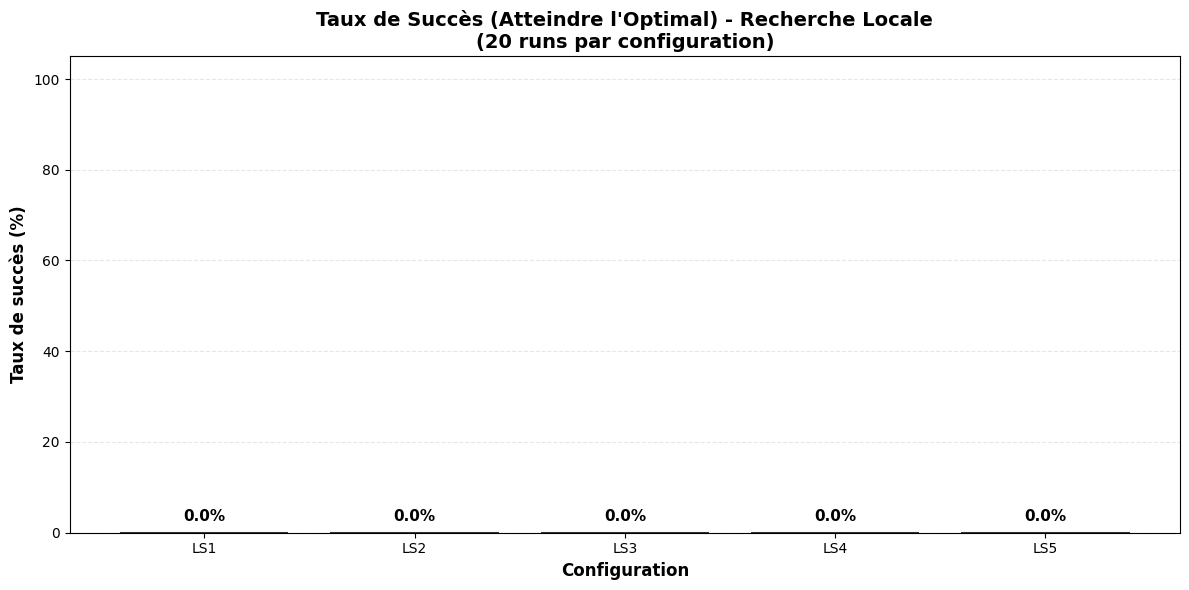

✓ Graphique 4 sauvegardé: 'floatpairs_ls_success_rate.png'


In [13]:
# Graphique 4: Taux de succès
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

config_names = list(results.keys())
success_rates = [results[c]['success_rate'] for c in config_names]

bars = ax.bar(config_names, success_rates,
              color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6'],
              alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Configuration', fontsize=12, fontweight='bold')
ax.set_ylabel('Taux de succès (%)', fontsize=12, fontweight='bold')
ax.set_title('Taux de Succès (Atteindre l\'Optimal) - Recherche Locale\n(20 runs par configuration)', 
             fontsize=14, fontweight='bold')
ax.set_ylim([0, 105])
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Annotations (dynamiques)
text_offset = 2  # Offset fixe de 2% au-dessus de la barre
for i, (bar, rate) in enumerate(zip(bars, success_rates)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + text_offset,
            f'{rate:.1f}%',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
#plt.savefig('floatpairs_ls_success_rate.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Graphique 4 sauvegardé: 'floatpairs_ls_success_rate.png'")

## 9. Analyse Comparative des Paramètres

In [14]:
print("="*80)
print("ANALYSE COMPARATIVE DES PARAMÈTRES")
print("="*80)

# Identification de la meilleure configuration
best_config = min(results.items(), key=lambda x: x[1]['mean'])
worst_config = max(results.items(), key=lambda x: x[1]['mean'])

print(f"\n🏆 MEILLEURE CONFIGURATION: {best_config[0]}")
print(f"   Description: {configurations[best_config[0]]['nom']}")
print(f"   Moyenne: {-best_config[1]['mean']:.2f} paires")
print(f"   Taux de succès: {best_config[1]['success_rate']:.1f}%")

print(f"\n❌ MOINS BONNE CONFIGURATION: {worst_config[0]}")
print(f"   Description: {configurations[worst_config[0]]['nom']}")
print(f"   Moyenne: {-worst_config[1]['mean']:.2f} paires")
print(f"   Taux de succès: {worst_config[1]['success_rate']:.1f}%")

# Analyse de l'effet de la probabilité de mutation
print("\n" + "="*80)
print("EFFET DE LA PROBABILITÉ DE MUTATION")
print("="*80)

for i, config_name in enumerate(config_names):
    pairs = -results[config_name]['mean']
    prob = mutation_probs[i]
    print(f"\n{config_name} (p={prob:.3f}): {pairs:.2f} paires")
    
    if pairs == -OPTIMAL_VALUE:
        print("   → Atteint l'optimal en moyenne ! ✓")
    else:
        distance = abs(-OPTIMAL_VALUE - pairs)
        print(f"   → Distance à l'optimal: {distance:.2f} paires")

print("\n" + "="*80)
print("OBSERVATIONS GÉNÉRALES")
print("="*80)
print("""
1. L'impact de la probabilité de mutation sur la recherche locale
2. Trade-off entre exploration (forte mutation) et exploitation (faible mutation)
3. La recherche locale converge rapidement mais peut rester dans un optimum local
4. Le temps d'exécution varie selon la probabilité de mutation
""")

print("="*80)

ANALYSE COMPARATIVE DES PARAMÈTRES

🏆 MEILLEURE CONFIGURATION: LS2
   Description: Mutation faible (0.25)
   Moyenne: 89.70 paires
   Taux de succès: 0.0%

❌ MOINS BONNE CONFIGURATION: LS1
   Description: Mutation par défaut (1/n)
   Moyenne: 71.45 paires
   Taux de succès: 0.0%

EFFET DE LA PROBABILITÉ DE MUTATION

LS1 (p=0.010): 71.45 paires
   → Distance à l'optimal: 27.55 paires

LS2 (p=0.250): 89.70 paires
   → Distance à l'optimal: 9.30 paires

LS3 (p=0.500): 89.55 paires
   → Distance à l'optimal: 9.45 paires

LS4 (p=0.750): 88.10 paires
   → Distance à l'optimal: 10.90 paires

LS5 (p=1.000): 86.80 paires
   → Distance à l'optimal: 12.20 paires

OBSERVATIONS GÉNÉRALES

1. L'impact de la probabilité de mutation sur la recherche locale
2. Trade-off entre exploration (forte mutation) et exploitation (faible mutation)
3. La recherche locale converge rapidement mais peut rester dans un optimum local
4. Le temps d'exécution varie selon la probabilité de mutation



## 10. Export des Résultats Détaillés

In [15]:
# Export des données détaillées pour chaque configuration
for config_name, res in results.items():
    detailed_df = pd.DataFrame({
        'Run': range(1, N_RUNS + 1),
        'Fitness': res['fitness_values'],
        'Pairs': [-f for f in res['fitness_values']],
        'Execution_Time': res['execution_times']
    })
    filename = f'floatpairs_ls_{config_name}_detailed.csv'
    detailed_df.to_csv(filename, index=False)
    print(f"✓ Détails de {config_name} exportés dans '{filename}'")

print("\n✓ Tous les fichiers ont été exportés avec succès !")

✓ Détails de LS1 exportés dans 'floatpairs_ls_LS1_detailed.csv'
✓ Détails de LS2 exportés dans 'floatpairs_ls_LS2_detailed.csv'
✓ Détails de LS3 exportés dans 'floatpairs_ls_LS3_detailed.csv'
✓ Détails de LS4 exportés dans 'floatpairs_ls_LS4_detailed.csv'
✓ Détails de LS5 exportés dans 'floatpairs_ls_LS5_detailed.csv'

✓ Tous les fichiers ont été exportés avec succès !
